In [1]:
from cerebralcortex.util.helper_methods import get_study_names
sn = get_study_names("/home/jupyter/cc3_conf/")
print(sn)
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType,MapType, StringType,ArrayType, FloatType, TimestampType, IntegerType
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
ModuleMetadata
from typing import List
import numpy as np
from scipy import signal
import pandas as pd
from cerebralcortex import Kernel
CC = Kernel("/home/jupyter/cc3_conf/", study_name='rice')
# CC.list_streams()

['admin', 'dartmouth_sobc', 'default', 'demo', 'jhu_cocaine', 'mars_study', 'mcontain', 'md2k_aa_rice', 'md2k_affsci', 'md2k_labtest', 'md2k_ses_utah', 'md2k_test', 'memphis-test', 'memphis_test_study', 'moffitt', 'moffitt-test', 'moods', 'moods_backup', 'moral', 'mperf', 'mperf-alabsi', 'mperf-buder', 'mperf-mit-ll', 'mperf-test', 'northwestern_smoking', 'nu', 'opioid_study', 'osu', 'rice', 'robas', 'robas_study', 'sobclab', 'test', 'utah', 'utah_p01', 'vermont', 'vermont_smoking', 'wesad']


In [ ]:
CC.get_stream('org.md2k.feature.motionsensehrv.decoded.leftwrist.all').count()

In [ ]:
# CC.get_stream('org.md2k.autosense.ecg.rr.winsorized.rice')
CC.search_stream('rr')

In [ ]:
def get_quality(data):
    outlier_threshold_high = 4000
    outlier_threshold_low = 20
    slope_threshold = 100
    eck_threshold_band_loose = 400
    minimum_expected_samples = 3*(0.33)*64
    data_quality_band_loose = 'Loose/Improper Attachment'
    data_quality_not_worn = 'Sensor off Body'
    data_quality_band_off = 'Battery down/Disconnected'
    data_quality_missing = 'Interittent Data Loss' 
    data_quality_good = 'Acceptable'
    acceptable_outlier_percent = 34
    if (len(data)== 0):
        return data_quality_band_off
    if (len(data)<=minimum_expected_samples) :
        return data_quality_missing
    range_data = max(data)-min(data)
    if range_data<=50:
        return data_quality_not_worn
    if range_data<=eck_threshold_band_loose:
        return data_quality_band_loose
    outlier_counts = 0 
    for i in range(0,len(data)):
        im,ip  = i,i
        if i==0:
            im = len(data)-1
        else:
            im = i-1
        if i == len(data)-1:
            ip = 0
        else:
            ip = ip+1
        stuck = ((data[i]==data[im]) and (data[i]==data[ip]))
        flip = ((abs(data[i]-data[im])>((int(outlier_threshold_high)))) or (abs(data[i]-data[ip])>((int(outlier_threshold_high)))))
        disc = ((abs(data[i]-data[im])>((int(slope_threshold)))) and (abs(data[i]-data[ip])>((int(slope_threshold)))))
        if disc:
            outlier_counts += 1
        elif stuck:
            outlier_counts +=1
        elif flip:
            outlier_counts +=1
        elif data[i] >= outlier_threshold_high:
            outlier_counts +=1
        elif data[i]<= outlier_threshold_low:
            outlier_counts +=1
    if (100*outlier_counts>acceptable_outlier_percent*len(data)):
        return data_quality_band_loose
    return data_quality_good

schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("quality", StringType()),
    StructField("ecg", DoubleType())
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_quality(key,data):
    data['quality'] = ''
    if data.shape[0]>0:
        data = data.sort_values('timestamp')
        data['quality'] = get_quality(list(data['ecg']))
    return data

stream_name = 'org.md2k.autosense.ecg.quality'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Chest ECG quality 3 seconds") \
    .add_dataDescriptor(
    DataDescriptor().set_name("quality").set_type("string").set_attribute("description", \
    "ECG data quality").set_attribute('Loose/Improper Attachment','Electrode Displacement').set_attribute('Sensor off Body',\
    'Autosense not worn').set_attribute('Battery down/Disconnected', \
    'No data is present - Can be due to battery down or sensor disconnection').set_attribute('Interittent Data Loss', \
     'Not enough samples are present').set_attribute('Acceptable','Good Quality')) \
    .add_dataDescriptor(
    DataDescriptor().set_name("ecg").set_type("double").set_attribute("description", \
    "ecg sample value")) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/ecg_quality.ipynb").set_attribute("url", "http://md2k.org/").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()

ecg_stream = 'ecg--org.md2k.autosense--autosense_chest--chest'
ecg = CC.get_stream(ecg_stream)
ecg_quality_stream = ecg.compute(ecg_quality,windowDuration=3,startTime='0 seconds')
ecg_quality_stream.printSchema()
data = ecg_quality_stream._data
ds = DataStream(data=data,metadata=stream_metadata)
CC.save_stream(ds)

In [ ]:
from collections import Counter
schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("quality", StringType())
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_quality_60(key,data):
    if data.shape[0]>0:
        quals = list(data['quality'].values)
        qual = Counter(quals).most_common()[0][0]
        data = data[:1].reset_index(drop=True)
        data['quality'].set_value(0,qual)
        data['start'] = [key[2]['start']]
        data['end'] = [key[2]['end']]
        return data[['start','end','timestamp','localtime','version','user','quality']]
    else:
        return pd.DataFrame([],columns=['start','end','timestamp','localtime','version','user','quality'])

stream_name = 'org.md2k.autosense.ecg.quality.60seconds'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Chest ECG quality 60 seconds") \
    .add_dataDescriptor(
    DataDescriptor().set_name("quality").set_type("string").set_attribute("description", \
    "ECG data quality").set_attribute('Loose/Improper Attachment','Electrode Displacement').set_attribute('Sensor off Body',\
    'Autosense not worn').set_attribute('Battery down/Disconnected', \
    'No data is present - Can be due to battery down or sensor disconnection').set_attribute('Interittent Data Loss', \
     'Not enough samples are present').set_attribute('Acceptable','Good Quality')) \
    .add_dataDescriptor(
    DataDescriptor().set_name("window").set_type("struct").set_attribute("description", \
    "window start and end time in UTC").set_attribute('start', \
    'start of 1 minute window').set_attribute('end','end of 1 minute window')) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/ecg_quality.ipynb").set_attribute("url", "http://md2k.org/").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))

stream_metadata.is_valid()

ecg_stream = 'org.md2k.autosense.ecg.quality'
ecg = CC.get_stream(ecg_stream)
ecg_quality_stream = ecg.compute(ecg_quality_60,windowDuration=60,startTime='0 seconds')
ecg_quality_stream = ecg_quality_stream.select('timestamp', F.struct('start', 'end').alias('window'),
                                   'localtime','quality','user','version')
ecg_quality_stream.printSchema()
data = ecg_quality_stream._data
ds = DataStream(data=data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
import numpy as np
from scipy.stats import iqr
from enum import Enum


class Quality(Enum):
    ACCEPTABLE = 1
    UNACCEPTABLE = 0

def outlier_computation(valid_rr_interval_time: list,
                        valid_rr_interval_sample: list,
                        criterion_beat_difference: float):
    """
    This function implements the rr interval outlier calculation through comparison with the criterion
    beat difference and consecutive differences with the previous and next sample

    :param valid_rr_interval_time: A python array of rr interval time
    :param valid_rr_interval_sample: A python array of rr interval samples
    :param criterion_beat_difference: A threshold calculated from the RR interval data passed

    yields: The quality of each data point in the RR interval array
    """
    standard_rr_interval_sample = valid_rr_interval_sample[0]
    previous_rr_interval_quality = Quality.ACCEPTABLE

    for i in range(1, len(valid_rr_interval_sample) - 1):

        rr_interval_diff_with_last_good = abs(standard_rr_interval_sample - valid_rr_interval_sample[i])
        rr_interval_diff_with_prev_sample = abs(valid_rr_interval_sample[i - 1] - valid_rr_interval_sample[i])
        rr_interval_diff_with_next_sample = abs(valid_rr_interval_sample[i] - valid_rr_interval_sample[i + 1])

        if previous_rr_interval_quality == Quality.UNACCEPTABLE and rr_interval_diff_with_last_good < criterion_beat_difference:
            yield (valid_rr_interval_time[i], Quality.ACCEPTABLE)
            previous_rr_interval_quality = Quality.ACCEPTABLE
            standard_rr_interval_sample = valid_rr_interval_sample[i]

        elif previous_rr_interval_quality == Quality.UNACCEPTABLE and rr_interval_diff_with_last_good > criterion_beat_difference >= rr_interval_diff_with_prev_sample and rr_interval_diff_with_next_sample <= criterion_beat_difference:
            yield (valid_rr_interval_time[i], Quality.ACCEPTABLE)
            previous_rr_interval_quality = Quality.ACCEPTABLE
            standard_rr_interval_sample = valid_rr_interval_sample[i]

        elif previous_rr_interval_quality == Quality.UNACCEPTABLE and rr_interval_diff_with_last_good > criterion_beat_difference and (
                        rr_interval_diff_with_prev_sample > criterion_beat_difference or rr_interval_diff_with_next_sample > criterion_beat_difference):
            yield (valid_rr_interval_time[i], Quality.UNACCEPTABLE)
            previous_rr_interval_quality = Quality.UNACCEPTABLE

        elif previous_rr_interval_quality == Quality.ACCEPTABLE and rr_interval_diff_with_prev_sample <= criterion_beat_difference:
            yield (valid_rr_interval_time[i], Quality.ACCEPTABLE)
            previous_rr_interval_quality = Quality.ACCEPTABLE
            standard_rr_interval_sample = valid_rr_interval_sample[i]

        elif previous_rr_interval_quality == Quality.ACCEPTABLE and rr_interval_diff_with_prev_sample > criterion_beat_difference:
            yield (valid_rr_interval_time[i], Quality.UNACCEPTABLE)
            previous_rr_interval_quality = Quality.UNACCEPTABLE

        else:
            yield (valid_rr_interval_time[i], Quality.UNACCEPTABLE)


def compute_outlier_ecg(ecg_ts,ecg_rr):
    """
    Reference - Berntson, Gary G., et al. "An approach to artifact identification: Application to heart period data."
    Psychophysiology 27.5 (1990): 586-598.

    :param ecg_rr: RR interval datastream

    :return: An annotated datastream specifying when the ECG RR interval datastream is acceptable
    """


    valid_rr_interval_sample = [i for i in ecg_rr if i > .3 and i < 2]
    valid_rr_interval_time = [ecg_ts[i] for i in range(len(ecg_ts)) if ecg_rr[i] > .3 and ecg_rr[i] < 2]
    valid_rr_interval_difference = abs(np.diff(valid_rr_interval_sample))

    # Maximum Expected Difference(MED)= 3.32* Quartile Deviation
    maximum_expected_difference = 4.5 * 0.5 * iqr(valid_rr_interval_difference)

    # Shortest Expected Beat(SEB) = Median Beat – 2.9 * Quartile Deviation
    # Minimal Artifact Difference(MAD) = SEB/ 3
    maximum_artifact_difference = (np.median(valid_rr_interval_sample) - 2.9 * .5 * iqr(
        valid_rr_interval_difference)) / 3

    # Midway between MED and MAD is considered
    criterion_beat_difference = (maximum_expected_difference + maximum_artifact_difference) / 2
    if criterion_beat_difference < .2:
        criterion_beat_difference = .2

    ecg_rr_quality_array = [(valid_rr_interval_time[0], Quality.ACCEPTABLE)]

    for data in outlier_computation(valid_rr_interval_time, valid_rr_interval_sample, criterion_beat_difference):
        ecg_rr_quality_array.append(data)
    ecg_rr_quality_array.append((valid_rr_interval_time[-1], Quality.ACCEPTABLE))
    return ecg_rr_quality_array

from typing import Tuple
from typing import List
import pandas as pd
import numpy as np

schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("rr", FloatType())
])
from ecgdetectors import Detectors
detectors = Detectors(64)
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_r_peak(key,data):
    if data.shape[0]>1000:
        data = data.sort_values('timestamp').reset_index(drop=True)
        index_all = np.array(list(range(data.shape[0])))
        rpeaks = detectors.hamilton_detector(data['ecg'].values)
        rpeaks = np.array(rpeaks)
        if len(rpeaks)<3:
            return pd.DataFrame([],columns=['timestamp','localtime','version','user','rr'])
        rpeak_ts = 1000*data['time'].values[rpeaks]
        ecg_rr_ts = rpeak_ts[1:]
        ecg_rr_val = np.diff(rpeak_ts)
        index_all = index_all[rpeaks][1:]
        
        index = np.where((ecg_rr_val>=400)&(ecg_rr_val<=2000))[0]
        if len(index)<3:
            return pd.DataFrame([],columns=['timestamp','localtime','version','user','rr'])
        
        ecg_rr_ts = ecg_rr_ts[index]
        ecg_rr_val = ecg_rr_val[index]
        index_all = index_all[index]
    
        outlier = compute_outlier_ecg(ecg_rr_ts/1000,ecg_rr_val/1000)
        index = []
        for ind,tup in enumerate(outlier):
            if tup[1]==Quality.ACCEPTABLE:
                index.append(ind)

        if len(index)<3:
            return pd.DataFrame([],columns=['timestamp','localtime','version','user','rr'])
        index = np.array(index)
        ecg_rr_ts = ecg_rr_ts[index]
        ecg_rr_val = ecg_rr_val[index]
        index_all = index_all[index]

        data = data.iloc[data.index[list(index_all)]]

        data['rr'] = list(np.float64(ecg_rr_val))

        data = data[['timestamp','localtime','version','user','rr']]
        return data
    else:
        return pd.DataFrame([],columns=['timestamp','localtime','version','user','rr'])



stream_name = 'org.md2k.autosense.ecg.rr.final.hamiltonian'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("ECG RR interval in milliseconds") \
    .add_dataDescriptor(
    DataDescriptor().set_name("rr").set_type("float").set_attribute("description", \
    "rr interval")) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/ecg_rr.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','pan-tomkins').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))

ecg_stream = 'org.md2k.autosense.ecg.quality'

ecg11 = CC.get_stream(ecg_stream)

ecg11 = ecg11.withColumn('time',F.col('timestamp').cast('double'))

ecg12 = ecg11.filter(F.col('quality')=='Acceptable')

ecg_filtered11 = ecg12.compute(ecg_r_peak,windowDuration=600,startTime='0 seconds')

print(stream_metadata.is_valid())

ecg_filtered11.metadata = stream_metadata

ecg_filtered11.show(5,False)

CC.save_stream(ecg_filtered11,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.ecg.rr.final.hamiltonian').count()

In [ ]:
rr_stream = 'org.md2k.autosense.ecg.rr.final.hamiltonian'
rr_intervals = CC.get_stream(rr_stream)
rr_intervals = rr_intervals.filter(F.col('rr')<1800)
rr_intervals = rr_intervals.filter(F.col('rr')>300)
rr_intervals = rr_intervals.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
rr_intervals.show(5,False)
from pyspark.sql import Window
import pyspark.sql.functions as F
percentile_90 = F.expr('percentile_approx(rr, 0.95)')
percentile_10 = F.expr('percentile_approx(rr, 0.05)')
percentiles_90 = rr_intervals.groupBy(['user','day']).agg(percentile_90.alias('90th'))
percentiles_10 = rr_intervals.groupBy(['user','day']).agg(percentile_10.alias('10th'))
data_90 = percentiles_90.toPandas()
data_10 = percentiles_10.toPandas()
data_90.set_index(['user','day'],inplace=True)
data_10.set_index(['user','day'],inplace=True)
def rr_winsorize(user,day,rr):
    upper = data_90.loc[user,day][0]
    lower = data_10.loc[user,day][0]
    if rr>upper:
        return np.float(upper)
    if rr<lower:
        return np.float(lower)
    return rr
rr_intervals.printSchema()
udf_winsorized = F.udf(rr_winsorize,FloatType()) 
rr_intervals_winsorized = rr_intervals.withColumn('rr',udf_winsorized('user','day','rr'))
rr_intervals_winsorized.show(10,False)
rr_intervals_winsorized = rr_intervals_winsorized.drop(*['day'])
stream_name = 'org.md2k.autosense.ecg.rr.winsorized.rice'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("winsorized ECG RR interval in milliseconds") \
    .add_dataDescriptor(
    DataDescriptor().set_name("rr").set_type("float").set_attribute("description", \
    "rr interval")) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/stress_from_rr_intervals.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','pan-tomkins').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
rr_intervals_winsorized.metadata = stream_metadata
CC.save_stream(rr_intervals_winsorized,overwrite=True)

In [ ]:
from cerebralcortex import Kernel
CC = Kernel("/home/jupyter/cc3_conf/", study_name='rice')
#CC.get_stream('org.md2k.autosense.ecg.rr.winsorized.rice',user_id='24770270-32bf-3229-8343-08cdc7fa8246').show(1,False)
CC.get_stream('org.md2k.autosense.ecg.rr.winsorized.rice').filter(F.col('user')=='24770270-32bf-3229-8343-08cdc7fa8246').show(1,False)

In [ ]:
from typing import List
import numpy as np
import scipy.signal as signal
import datetime
from scipy.stats import iqr


# def get_rr_features(a):
#     return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])

import numpy as np
from scipy.stats import iqr
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as mpatches
from collections import OrderedDict

# def frequencyDomain(RRints,tmStamps, band_type = None, lf_bw = 0.11, hf_bw = 0.1, plot = 0):
    
#     #Remove ectopic beats
#     #RR intervals differing by more than 20% from the one proceeding it are removed
#     NNs = []
#     tss = []
#     for c, rr in enumerate(RRints):        
#         if abs(rr - RRints[c-1]) <= 0.20 * RRints[c-1]:
#             NNs.append(rr)
#             tss.append(tmStamps[c])
            
            
#     frequency_range = np.linspace(0.001, 1, 10000)
#     NNs = np.array(NNs)
#     NNs = NNs - np.mean(NNs)
#     result = signal.lombscargle(tss, NNs, frequency_range)
        
#     #Pwelch w/ zero pad     
#     fxx = frequency_range 
#     pxx = result 
    
#     vlf= (0.003, 0.04)
#     lf = (0.04, 0.15)
#     hf = (0.15, 0.4)
    
#     plot_labels = ['VLF', 'LF', 'HF']
        
#     if band_type == 'adapted':     
            
#         vlf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])]))[0][0]] 
#         lf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])]))[0][0]]
#         hf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])]))[0][0]]
    
#         peak_freqs =  (vlf_peak, lf_peak, hf_peak) 
            
#         hf = (peak_freqs[2] - hf_bw/2, peak_freqs[2] + hf_bw/2)
#         lf = (peak_freqs[1] - lf_bw/2, peak_freqs[1] + lf_bw/2)   
#         vlf = (0.003, lf[0])
        
#         if lf[0] < 0:
#             print('***Warning***: Adapted LF band lower bound spills into negative frequency range')
#             print('Lower thresold of LF band has been set to zero')
#             print('Adjust LF and HF bandwidths accordingly')
#             lf = (0, lf[1])        
#             vlf = (0, 0)
#         elif hf[0] < 0:
#             print('***Warning***: Adapted HF band lower bound spills into negative frequency range')
#             print('Lower thresold of HF band has been set to zero')
#             print('Adjust LF and HF bandwidths accordingly')
#             hf = (0, hf[1])        
#             lf = (0, 0)        
#             vlf = (0, 0)
            
#         plot_labels = ['Adapted_VLF', 'Adapted_LF', 'Adapted_HF']

#     df = fxx[1] - fxx[0]
#     vlf_power = np.trapz(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])], dx = df)      
#     lf_power = np.trapz(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])], dx = df)            
#     hf_power = np.trapz(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])], dx = df)             
#     totalPower = vlf_power + lf_power + hf_power
    
#     #Normalize and take log
#     vlf_NU_log = np.log((vlf_power / (totalPower - vlf_power)) + 1)
#     lf_NU_log = np.log((lf_power / (totalPower - vlf_power)) + 1)
#     hf_NU_log = np.log((hf_power / (totalPower - vlf_power)) + 1)
#     lfhfRation_log = np.log((lf_power / hf_power) + 1)   
    
#     freqDomainFeats = {'VLF_Power': vlf_NU_log, 'LF_Power': lf_NU_log,
#                        'HF_Power': hf_NU_log, 'LF/HF': lfhfRation_log}
                       
#     if plot == 1:
#         #Plot option
#         freq_bands = {'vlf': vlf, 'lf': lf, 'hf': hf}
#         freq_bands = OrderedDict(sorted(freq_bands.items(), key=lambda t: t[0]))
#         colors = ['lightsalmon', 'lightsteelblue', 'darkseagreen']
#         fig, ax = plt.subplots(1)
#         ax.plot(fxx, pxx, c = 'grey')
#         plt.xlim([0, 0.40])
#         plt.xlabel(r'Frequency $(Hz)$')
#         plt.ylabel(r'PSD $(s^2/Hz$)')
        
#         for c, key in enumerate(freq_bands):
#             ax.fill_between(fxx[min(np.where(fxx >= freq_bands[key][0])[0]): max(np.where(fxx <= freq_bands[key][1])[0])],
#                             pxx[min(np.where(fxx >= freq_bands[key][0])[0]): max(np.where(fxx <= freq_bands[key][1])[0])],
#                             0, facecolor = colors[c])
            
#         patch1 = mpatches.Patch(color = colors[0], label = plot_labels[2])
#         patch2 = mpatches.Patch(color = colors[1], label = plot_labels[1])
#         patch3 = mpatches.Patch(color = colors[2], label = plot_labels[0])
#         plt.legend(handles = [patch1, patch2, patch3])
#         plt.show()

#     return freqDomainFeats

from typing import List
import numpy as np
import scipy.signal as signal
import datetime
from scipy.stats import iqr
import numpy as np
from scipy.stats import iqr
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as mpatches
from collections import OrderedDict

def frequencyDomain(tmStamps,RRints, lf_bw = 0.11, hf_bw = 0.1):
    
    #Remove ectopic beats
    #RR intervals differing by more than 20% from the one proceeding it are removed
    NNs = []
    tss = []
    for c, rr in enumerate(RRints):        
        if abs(rr - RRints[c-1]) <= 0.20 * RRints[c-1]:
            NNs.append(rr)
            tss.append(tmStamps[c])
            
            
    frequency_range = np.linspace(0.001, 1, 10000)
    NNs = np.array(NNs)
    NNs = NNs - np.mean(NNs)
    result = signal.lombscargle(tss, NNs, frequency_range)
        
    #Pwelch w/ zero pad     
    fxx = frequency_range 
    pxx = result 
    
    vlf= (0.003, 0.04)
    lf = (0.04, 0.15)
    hf = (0.15, 0.4)
    
    plot_labels = ['VLF', 'LF', 'HF']
        
    df = fxx[1] - fxx[0]
    vlf_power = np.trapz(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])], dx = df)      
    lf_power = np.trapz(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])], dx = df)            
    hf_power = np.trapz(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])], dx = df)             
    totalPower = vlf_power + lf_power + hf_power
    
    #Normalize and take log
    vlf_NU_log = np.log((vlf_power / (totalPower - vlf_power)) + 1)
    lf_NU_log = np.log((lf_power / (totalPower - vlf_power)) + 1)
    hf_NU_log = np.log((hf_power / (totalPower - vlf_power)) + 1)
    lfhfRation_log = np.log((lf_power / hf_power) + 1)   
    
    freqDomainFeats = {'VLF_Power': vlf_NU_log, 'LF_Power': lf_NU_log,
                       'HF_Power': hf_NU_log, 'LF/HF': lfhfRation_log}
                       
    return freqDomainFeats



def ecg_feature_computation(b,a):
    return [np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)]+list(frequencyDomain(b/1000,a/1000).values())

rr_stream = 'org.md2k.autosense.ecg.rr.winsorized.rice'
rr_data = CC.get_stream(rr_stream)
rr_data = rr_data.withColumn('time',F.col('timestamp').cast('double'))
rr_data.printSchema()
schema = StructType([StructField("timestamp", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("features", ArrayType(DoubleType()))
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_r_peak(key,data):
    if data.shape[0]>20:
        data = data.sort_values('time').reset_index(drop=True)
        data['time'] = data['time'].apply(lambda a:a*1000)
        a = data['rr'].values
        try: 
            features = ecg_feature_computation(np.cumsum(a),np.array(a))
        except:
            return pd.DataFrame([],columns=['timestamp','localtime','version','user','features','start','end'])
#         [np.double(np.array(list(get_rr_features(a))+list(frequencyDomain(np.array(a)/1000,np.cumsum(a)/1000).values())))]
        return pd.DataFrame([[data['timestamp'].values[0],
                            data['localtime'].values[0],
                            1,
                            data['user'].values[0],
                            key[2]['start'],
                            key[2]['end'],
                            features]],columns = ['timestamp','localtime','version','user','start','end','features'])
#         data = data[:1]
#         data['features'] = [features]
#         data['start'] = [key[2]['start']]
#         data['end'] = [key[2]['end']]
#         data = data[['timestamp','localtime','version','user','start','end','features']]
#         return data
    else:
        return pd.DataFrame([],columns=['timestamp','localtime','version','user','features','start','end'])

ecg_features = rr_data.compute(ecg_r_peak,windowDuration=60,startTime='0 seconds',slideDuration=5)
ecg_features.show(50,False)
ecg_features = ecg_features.select('timestamp', F.struct('start', 'end').alias('window'), 'localtime','features','user','version')
stream_name = 'org.md2k.autosense.ecg.features.rice'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Features computed for ECG stress model per minute") \
    .add_dataDescriptor(
    DataDescriptor().set_name("features").set_type("array").set_attribute("description", \
    "ecg features per minute - var,iqr,vlf,lf,hf,lfhf,mean,median,80th,20th,hr")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("window").set_type("struct").set_attribute("description", \
    "window start and end time in UTC").set_attribute('start', \
    'start of 1 minute window').set_attribute('end','end of 1 minute window')) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/stress_from_rr_interval.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','ecg feature computation').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
ecg_features.metadata = stream_metadata
CC.save_stream(ecg_features,overwrite=True)

In [ ]:
activity_data = CC.get_stream('org.md2k.autosense.accel.activity.60seconds')
rr_stream = 'org.md2k.autosense.ecg.features.rice'
df = CC.get_stream(rr_stream)
df = df.join(activity_data.drop(*['timestamp','localtime','version']),on=['user','window'],how='left')
df = df.filter(F.col('activity')!=1)
df = df.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
stream_name = 'org.md2k.autosense.ecg.features.stndardized.rice.no.activity'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Features computed for ECG stress model per minute") \
    .add_dataDescriptor(
    DataDescriptor().set_name("features").set_type("array").set_attribute("description", \
    "ecg features per minute - var,iqr,vlf,lf,hf,lfhf,mean,median,80th,20th,hr")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("window").set_type("struct").set_attribute("description", \
    "window start and end time in UTC").set_attribute('start', \
    'start of 1 minute window').set_attribute('end','end of 1 minute window')) \
    .add_dataDescriptor(
    DataDescriptor().set_name("day").set_type("string").set_attribute("description", \
    "day in string format")) \
    .add_module( 
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/stress_from_rr_interval.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','ecg feature computation').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
    
df.metadata = stream_metadata
df.show(2,False)
CC.save_stream(df,overwrite=True)

In [ ]:
feature_stream = 'org.md2k.autosense.ecg.features.stndardized.rice.no.activity'
ecg_features = CC.get_stream(feature_stream).dropna()
ecg_features = ecg_features.withColumn('start',F.col('window').start)
ecg_features = ecg_features.withColumn('end',F.col('window').end)
ecg_features = ecg_features.drop(*['window'])
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("stress_likelihood", DoubleType())
])
import pickle
ecg_model = pickle.load(open('./models/ecg_model.p','rb'))
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_r_peak(key,data):
    if data.shape[0]>60*12*0.66:
        features = []
        for i in range(data.shape[0]):
            features.append(np.array(data['features'][i]))
        features = np.array(features)
        features = StandardScaler().fit_transform(np.nan_to_num(features))
        probs = ecg_model.predict_proba(np.nan_to_num(features))[:,1]
        data['stress_likelihood'] = probs
        data = data[['timestamp','start','end','version','user','localtime','stress_likelihood','day']]
        return data
    else:
        return pd.DataFrame([],columns=['timestamp','version','user','localtime','stress_likelihood','start','end','day'])

ecg_likelihoods = ecg_features.groupBy(['user','version','day']).apply(ecg_r_peak)
ecg_stress = ecg_likelihoods.select('timestamp', F.struct('start', 'end').alias('window'), 'localtime','stress_likelihood','user','version')
stream_name = 'org.md2k.autosense.ecg.stress.likelihood.rice.no.activity'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("stress likelihood computed from ECG features") \
    .add_dataDescriptor(
    DataDescriptor().set_name("stress_likelihood").set_type("double").set_attribute("description", \
    "stress likelihood computed from ECG only model").set_attribute("threshold","0.47")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("window").set_type("struct").set_attribute("description", \
    "window start and end time in UTC").set_attribute('start', \
    'start of 1 minute window').set_attribute('end','end of 1 minute window')) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/ecg_stress_likelihood.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','cstress').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
ecg_stress = DataStream(data=ecg_stress,metadata=stream_metadata)
ecg_stress.printSchema()
ecg_stress.show(5,False)
CC.save_stream(ecg_stress,overwrite=True)

In [ ]:
data = CC.get_stream('org.md2k.autosense.ecg.stress.likelihood.rice.no.activity')

In [ ]:
data = data.toPandas()

In [3]:
import pickle

In [4]:
data = pickle.load(open('./data/rice_1st_version_ecg_only.p','rb'))

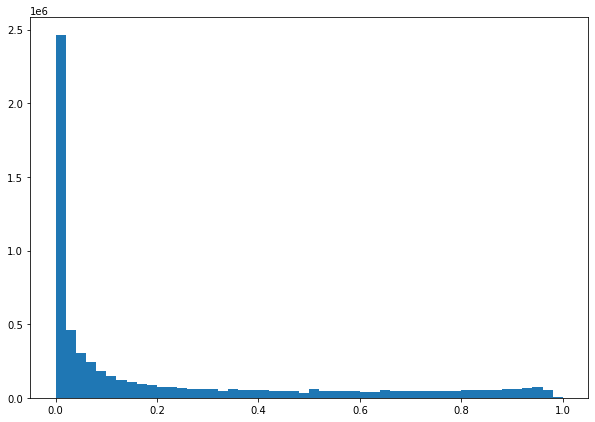

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(data['stress_likelihood'],50)
plt.show()

In [ ]:
pickle.dump(data,open('./data/rice_1st_version_ecg_only.p','wb'))

In [ ]:
stress_data = CC.get_stream('org.md2k.autosense.ecg.stress.likelihood.md2k_aa_rice.no.activity')
stress_data = stress_data.withColumn('day',F.date_format('localtime',"YYYYMMdd"))
stress_data = stress_data.withColumn('start',F.col('window').start)
stress_data = stress_data.withColumn('end',F.col('window').end).drop(*['window'])
stress_data = stress_data.withColumn('start',F.col('start').cast('double'))
stress_data = stress_data.withColumn('end',F.col('end').cast('double'))
stress_data = stress_data.withColumn('localtime',F.col('localtime').cast('double'))
stress_data = stress_data.withColumn('timestamp',F.col('timestamp').cast('double'))
stress_data.printSchema()

schema = StructType([StructField("timestamp", DoubleType()),
    StructField("start", DoubleType()),
    StructField("end", DoubleType()),
    StructField("localtime", DoubleType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("stress_likelihood", DoubleType()),
    StructField("imputed", IntegerType())])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def impute_forwardfill(data):
    data = data.sort_values('start').reset_index(drop=True)
    start = data['start'][0]
    all_rows = []
    for i,row in data.iterrows():
        if row['start']==start:
            all_rows.append([row['timestamp'],row['localtime'],row['start'],row['end'],
                             row['version'],row['user'],row['day'],row['stress_likelihood'],0])
            start = row['end']
        else:
            k = 1
            while (start+k*60)<=row['start']:
                all_rows.append([data.loc[i-1]['timestamp']+k*60,data.loc[i-1]['localtime']+k*60,
                                 data.loc[i-1]['start']+k*60,data.loc[i-1]['end']+k*60,
                                 row['version'],row['user'],row['day'],data.loc[i-1]['stress_likelihood'],1])
                k+=1
            all_rows.append([row['timestamp'],row['localtime'],row['start'],row['end'],
                             row['version'],row['user'],row['day'],row['stress_likelihood'],0])
            start = row['end']    
    return pd.DataFrame(all_rows,columns=['timestamp','localtime','start','end',
                                          'version','user','day','stress_likelihood','imputed'])
stress_imputed_data = stress_data.groupBy(['user','day']).apply(impute_forwardfill)

stress_imputed_data = stress_imputed_data.withColumn('start',F.col('start').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('end',F.col('end').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('localtime',F.col('localtime').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('timestamp',F.col('timestamp').cast('timestamp'))
cols = list(stress_imputed_data.columns)
cols.append(F.struct('start', 'end').alias('window'))
cols.remove('start')
cols.remove('end')
stress_imputed_data = stress_imputed_data.select(*cols)
schema = stress_imputed_data.schema
stream_metadata = Metadata()
stream_metadata.set_name("org.md2k.autosense.ecg.stress.likelihood.md2k_aa_rice.no.activity.imputed.ffill").set_description("stress imputed")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("stress forward fill imputer") \
    .set_attribute("url", "hhtps://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=stress_imputed_data,metadata=stream_metadata)
CC.save_stream(ds)

In [ ]:
# ecg_stress.count()*100/ds.count()
ds = CC.get_stream("org.md2k.autosense.ecg.stress.likelihood.md2k_aa_rice.no.activity.imputed.ffill")
emas = CC.get_stream("perceived.stress.score--org.md2k.ema_scheduler--phone").drop(*['timestamp',
                                                                                    'localtime',
                                                                                    'version'])
all_stress = ds.join(emas,on=['user','window'],how='left')

schema = all_stress.schema
stream_metadata = Metadata()
stream_metadata.set_name("stress_and_perceived_stress_score").set_description("stress imputed, ema filled")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("stress forward fill imputer and ema filler") \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=all_stress._data,metadata=stream_metadata)
CC.save_stream(ds)

In [ ]:
data = CC.get_stream("stress_and_perceived_stress_score")
data = data.withColumn('day',F.date_format('localtime',"YYYYMMdd"))
data = data.withColumn('time',F.col('timestamp').cast('double'))
stress_pd_data = data._data.toPandas()
import pickle
pickle.dump(stress_pd_data,open('./rice_data/stress_ema_md2k_aa_rice.p','wb'))

In [ ]:
emas.printSchema

In [ ]:
data = pickle.load(open('./rice_data/stress_again1.p','rb'))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data['stress_likelihood'][:600])

In [ ]:
data.groupby('user').count()

In [ ]:
plt.plot(data[data.user.isin(['fe6a5545-ca7b-38e2-aa0d-021c5e675f15'])]['stress_likelihood'][2000:2060])

In [ ]:
data['stress_likelihood']

In [ ]:
data.shape[0]/60/150

In [ ]:
data.sort_values('timestamp')

In [ ]:
activity_data.count()

In [ ]:
18607/(60*75)

In [ ]:
CC.list_users()

In [ ]:
# import shutil
# shutil.make_archive(output_filename, 'zip', dir_name)
# activity_data = CC.get_stream('org.md2k.autosense.accel.activity.60seconds')
# rr_stream = 'org.md2k.autosense.ecg.features.rice'
# df = CC.get_stream(rr_stream)
# df = df.join(activity_data.drop(*['timestamp','localtime','version']),on=['user','window'],how='left')
# df = df.filter(F.col('activity')!=1)
# df = df.drop(*['activity'])
# df = df.withColumn('var', F.col('features').getItem(0))
# df = df.withColumn('iqr', F.col('features').getItem(1))
# df = df.withColumn('vlf', F.col('features').getItem(7))
# df = df.withColumn('lf', F.col('features').getItem(8))
# df = df.withColumn('hf', F.col('features').getItem(9))
# df = df.withColumn('lfhf', F.col('features').getItem(10))
# df = df.withColumn('mean', F.col('features').getItem(2))
# df = df.withColumn('median', F.col('features').getItem(3))
# df = df.withColumn('80th', F.col('features').getItem(4))
# df = df.withColumn('20th', F.col('features').getItem(5))
# df = df.withColumn('heartrate', F.col('features').getItem(6))
# df = df.drop(*['features'])

# df = df.withColumn('day',F.date_format('localtime',"yyyyMMdd"))

# std_all = df.groupBy(['user','day']).agg(F.stddev('var').alias('var'),F.stddev('iqr').alias('iqr'),
#                                F.stddev('vlf').alias('vlf'),F.stddev('lf').alias('lf'),
#                                F.stddev('hf').alias('hf'),F.stddev('lfhf').alias('lfhf'),
#                                F.stddev('mean').alias('mean'),F.stddev('median').alias('median'),
#                                F.stddev('80th').alias('80th'),F.stddev('20th').alias('20th'),
#                                F.stddev('heartrate').alias('heartrate')).toPandas()
# mean_all = df.groupBy(['user','day']).agg(F.mean('var').alias('var'),F.mean('iqr').alias('iqr'),
#                                F.mean('vlf').alias('vlf'),F.mean('lf').alias('lf'),
#                                F.mean('hf').alias('hf'),F.mean('lfhf').alias('lfhf'),
#                                F.mean('mean').alias('mean'),F.mean('median').alias('median'),
#                                F.mean('80th').alias('80th'),F.mean('20th').alias('20th'),
#                                F.mean('heartrate').alias('heartrate')).toPandas()

# mean_all.set_index(['user','day'],inplace=True)
# std_all.set_index(['user','day'],inplace=True)

# df = df.withColumn('start',F.col('window').start).withColumn('end',F.col('window').end).drop(*['window'])
# schema = StructType([
#     StructField("timestamp", TimestampType()),
#     StructField("localtime", TimestampType()),
#     StructField("start", TimestampType()),
#     StructField("end", TimestampType()),
#     StructField("version", IntegerType()),
#     StructField("user", StringType()),
#     StructField("var", DoubleType()),
#     StructField("iqr", DoubleType()),
#     StructField("vlf", DoubleType()),
#     StructField("lf", DoubleType()),
#     StructField("hf", DoubleType()),
#     StructField("lfhf", DoubleType()),
#     StructField("mean", DoubleType()),
#     StructField("median", DoubleType()),
#     StructField("80th", DoubleType()),
#     StructField("20th", DoubleType()),
#     StructField("heartrate", DoubleType()),
#     StructField("day", StringType())
# ])

# @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# def peak_valley(key,data):
#     columns = ['var','iqr','mean','median','80th','20th','heartrate','vlf','lf','hf','lfhf']
#     if data.shape[0]>1:
#         for i in range(data.shape[0]):
#             for c in columns:
#                 m = mean_all.loc[data.loc[i]['user'],data.loc[i]['day']][c]
#                 s = std_all.loc[data.loc[i]['user'],data.loc[i]['day']][c]
#                 t = (data.loc[i][c] - m)/s
#                 data[c].set_value(i,t)                    
#         return data                
#     else:
#         return pd.DataFrame([],columns=columns+['user','version','timestamp','localtime','start','end','day'])

# dfstandardized = df.compute(peak_valley,startTime='0 seconds',windowDuration=600)

# columns = ['var','iqr','mean','median','80th','20th','heartrate','vlf','lf','hf','lfhf']
# df_final = dfstandardized.select("user",'version','timestamp','localtime','day',
#               F.struct('start', 'end').alias('window'),F.array([F.col(i) for i in columns]).alias("features"))

# df_final.printSchema()

# stream_name = 'org.md2k.autosense.ecg.features.stndardized.md2k_aa_rice.no.activity'
# stream_metadata = Metadata()
# stream_metadata.set_name(stream_name).set_description("Features computed for ECG stress model per minute") \
#     .add_dataDescriptor(
#     DataDescriptor().set_name("features").set_type("array").set_attribute("description", \
#     "ecg features per minute - var,iqr,vlf,lf,hf,lfhf,mean,median,80th,20th,hr")) \
#     .add_dataDescriptor(
#     DataDescriptor().set_name("window").set_type("struct").set_attribute("description", \
#     "window start and end time in UTC").set_attribute('start', \
#     'start of 1 minute window').set_attribute('end','end of 1 minute window')) \
#     .add_dataDescriptor(
#     DataDescriptor().set_name("day").set_type("string").set_attribute("description", \
#     "day in string format")) \
#     .add_module( 
#     ModuleMetadata().set_name("fourtytwo/mullah/cc3/stress_from_rr_interval.ipynb").set_attribute("url", \
#     "http://md2k.org/").set_attribute('algorithm','ecg feature computation').set_attribute('unit', \
#     'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
    
# df_final.metadata = stream_metadata
# CC.save_stream(df_final,overwrite=True)